In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
SEED = 42
CSV_PATH = '../dataset/csv/citrus.csv'

## データ読み込み + 各種プロット

- 欠損値: 無し

- 目的変数の数: orange, gapefruitともに5000個

- プロット結果から言えること: diameterで比較的分離できそう

In [3]:
df = pd.read_csv(CSV_PATH)
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [4]:
# 欠損値の有無確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [5]:
# 目的変数数確認
# orange, gapefruitともに5000個
df['name'].value_counts()

orange        5000
grapefruit    5000
Name: name, dtype: int64

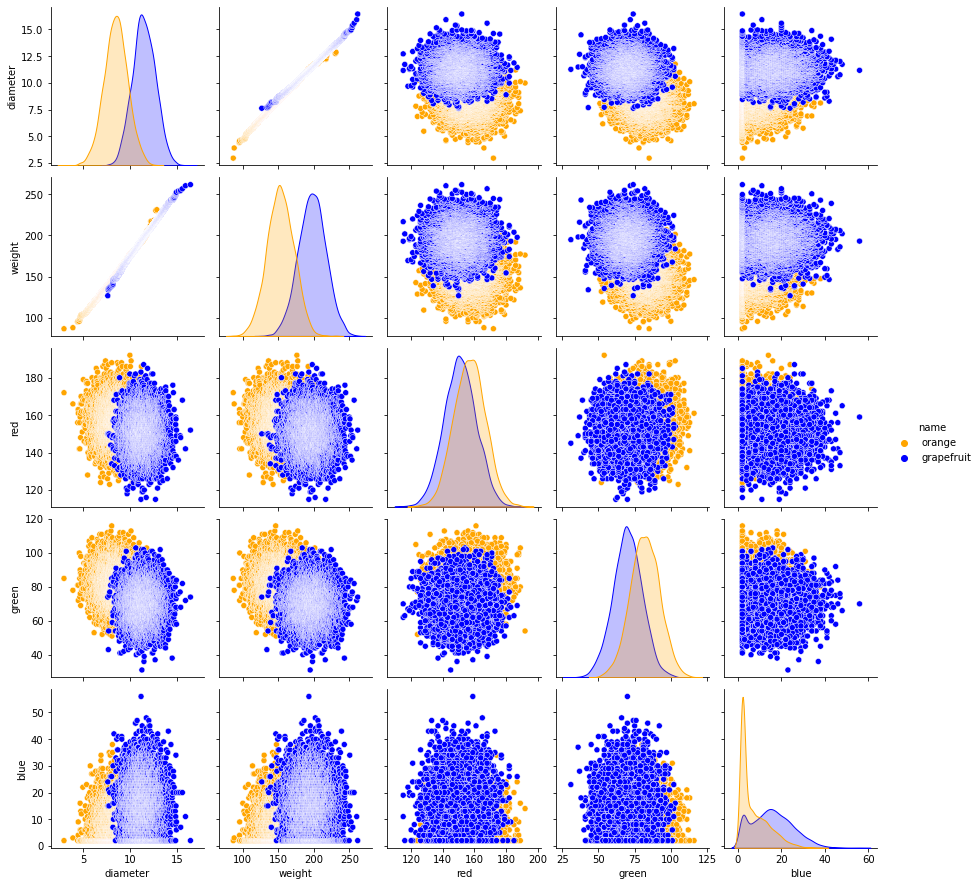

In [20]:
# ペアプロット
sns.pairplot(data=df, hue='name', palette={'orange': 'orange', 'grapefruit': 'b'})
plt.show()

## 密度を加えた場合

In [13]:
def get_density_added_df(df):
    df = df.copy()
    r = df['diameter'] / 2
    volume = 4 / 3 * np.pi * r ** 3
    density = df['weight'] / volume
    df['density'] = density
    return df

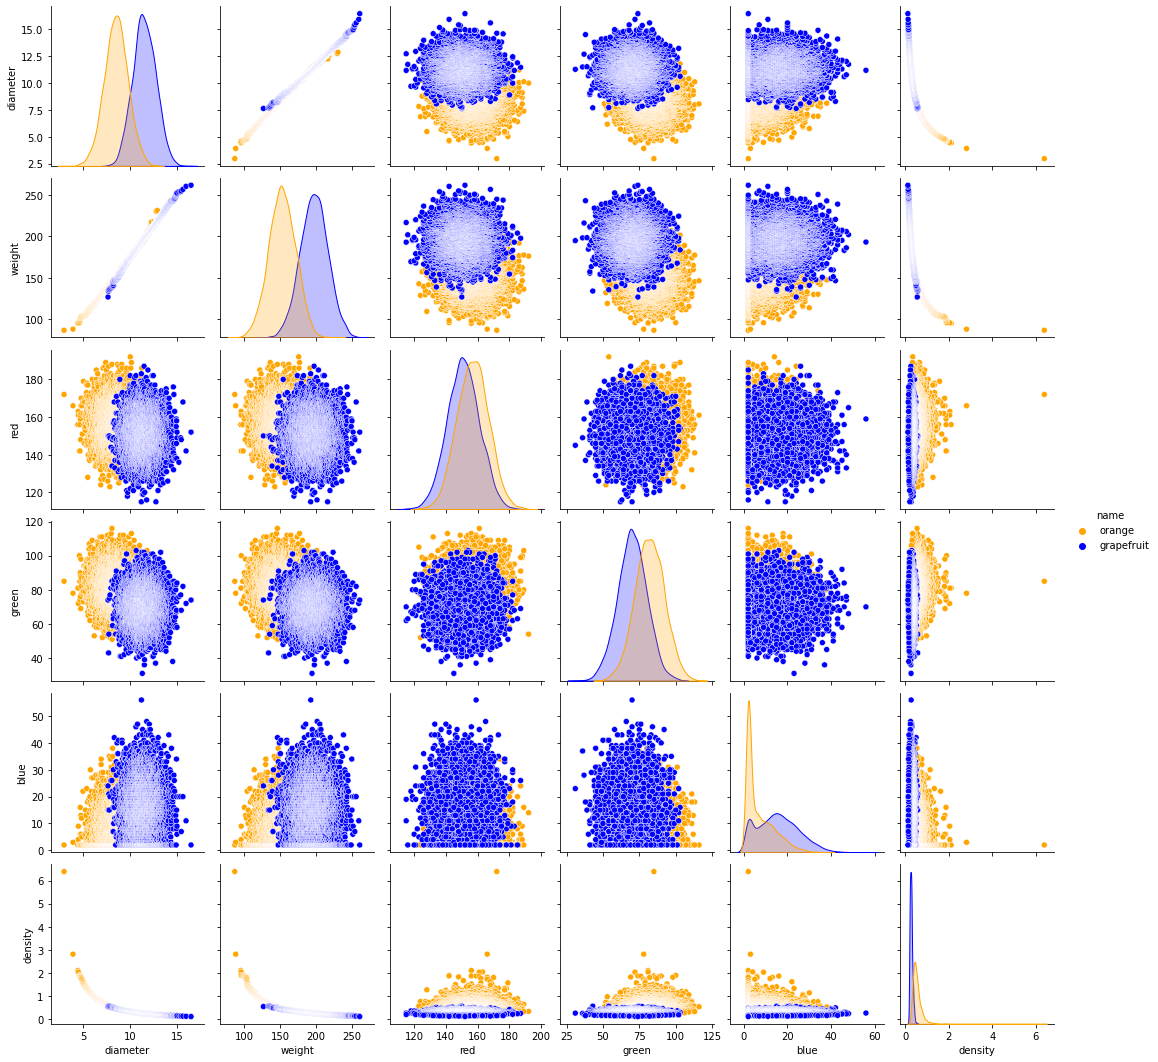

In [27]:
df = pd.read_csv(CSV_PATH)
df = get_density_added_df(df)
sns.pairplot(data=df, hue='name', palette={'orange': 'orange', 'grapefruit': 'b'})
plt.show()

## 変数をそのままいれた場合と密度特徴量をいれた場合で比較

In [18]:
label2id = {label: i for i, label in enumerate(df['name'].unique())}

def get_model():
    return Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])


def run_cross_validation(X, y, cv=5):
    model = get_model()
    cv_result = cross_validate(model, X, y, cv=cv, scoring=['accuracy'])
    return cv_result


def finalize_model(X_train, y_train):
    model = get_model()
    model.fit(X_train, y_train)
    return model


def get_dataset(df):
    X, y = df.drop('name', axis=1), df['name'].apply(lambda x: label2id[x])
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [11]:
# 変数をそのまま使用した場合
df = pd.read_csv(CSV_PATH)
X_train, _, y_train, _ = get_dataset(df)
cv_res = run_cross_validation(X_train, y_train)
print(f'acc: {cv_res["test_accuracy"].mean():.3f} +/- {cv_res["test_accuracy"].std():.3f}')

acc: 0.938 +/- 0.003


In [15]:
# 密度特徴量をいれた場合
df = pd.read_csv(CSV_PATH)
df = get_density_added_df(df)
X_train, _, y_train, _ = get_dataset(df)
cv_res = run_cross_validation(X_train, y_train)
print(f'acc: {cv_res["test_accuracy"].mean():.3f} +/- {cv_res["test_accuracy"].std():.3f}')

acc: 0.940 +/- 0.003


## 密度特徴量を入れたモデルで学習 + 評価

In [19]:
# データセット作成
df = pd.read_csv(CSV_PATH)
df = get_density_added_df(df)
X_train, X_test, y_train, y_test = get_dataset(df)
# 学習
model = finalize_model(X_train, y_train)

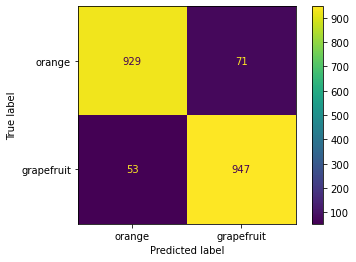

              precision    recall  f1-score   support

      orange       0.95      0.93      0.94      1000
  grapefruit       0.93      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [30]:
# 評価
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
labels = list(label2id.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, target_names=labels))